# Rattlers Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 24 # rattlers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134 entries, 0 to 5133
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              5134 non-null   int64  
 1   dimCustomerMasterId       5134 non-null   int64  
 2   customerNumber            5134 non-null   object 
 3   year                      5134 non-null   object 
 4   productGrouping           5134 non-null   object 
 5   totalSpent                5134 non-null   float64
 6   recentDate                5134 non-null   object 
 7   attendancePercent         5134 non-null   float64
 8   renewedBeforeDays         5134 non-null   int64  
 9   isBuyer                   5134 non-null   object 
 10  source_tenure             5134 non-null   int64  
 11  tenure                    5134 non-null   int64  
 12  distToVenue               5134 non-null   float64
 13  totalGames                5134 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134 entries, 0 to 5133
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          5134 non-null   int64  
 1   dimCustomerMasterId   5134 non-null   int64  
 2   customerNumber        5134 non-null   object 
 3   year                  5134 non-null   object 
 4   productGrouping       5134 non-null   object 
 5   totalSpent            5134 non-null   float64
 6   recentDate            5134 non-null   object 
 7   attendancePercent     5134 non-null   float64
 8   renewedBeforeDays     5134 non-null   int64  
 9   isBuyer               5134 non-null   object 
 10  source_tenure         5134 non-null   int64  
 11  tenure                5134 non-null   int64  
 12  distToVenue           5134 non-null   float64
 13  totalGames            5134 non-null   int64  
 14  recency               5134 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (4621, 47)
Unseen Data For Predictions: (513, 47)
Data for Modeling (A Class): (4621, 47)
Unseen Data For Predictions: (513, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(5134, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134 entries, 0 to 5133
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  5134 non-null   int64  
 1   attendancePercent    5134 non-null   float64
 2   renewedBeforeDays    5134 non-null   int64  
 3   source_tenure        5134 non-null   int64  
 4   tenure               5134 non-null   int64  
 5   totalGames           5134 non-null   int64  
 6   recency              5134 non-null   int64  
 7   missed_games_1       5134 non-null   int64  
 8   missed_games_over_2  5134 non-null   int64  
 9   isNextYear_Buyer     5134 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 401.2 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,-0.01,0.12,0.23,0.23,0.06,-0.05,-0.00,0.07,0.14
attendancePercent,-0.01,1.00,0.12,-0.07,-0.07,0.33,-0.32,0.24,-0.42,0.10
renewedBeforeDays,0.12,0.12,1.00,0.25,0.25,0.06,-0.08,0.01,-0.06,0.16
source_tenure,0.23,-0.07,0.25,1.00,1.00,-0.05,-0.09,-0.10,-0.00,-0.07
tenure,0.23,-0.07,0.25,1.00,1.00,-0.05,-0.09,-0.10,-0.00,-0.07
totalGames,0.06,0.33,0.06,-0.05,-0.05,1.00,-0.10,0.59,0.38,0.16
recency,-0.05,-0.32,-0.08,-0.09,-0.09,-0.10,1.00,-0.09,0.25,-0.07
missed_games_1,-0.00,0.24,0.01,-0.10,-0.10,0.59,-0.09,1.00,0.11,0.10
missed_games_over_2,0.07,-0.42,-0.06,-0.00,-0.00,0.38,0.25,0.11,1.00,0.05
isNextYear_Buyer,0.14,0.10,0.16,-0.07,-0.07,0.16,-0.07,0.10,0.05,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4107, 10)
Unseen Data For Predictions: (1027, 10)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "recency",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,8076
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(4107, 10)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(0       1
 1       0
 2       1
 3       0
 4       1
        ..
 4102    0
 4103    1
 4104    1
 4105    1
 4106    1
 Name: isNextYear_Buyer, Length: 4107, dtype: int64,
       dimCustomerMasterId  attendancePercent  renewedBeforeDays  \
 0               386141546           1.083333                179   
 1               351993755           0.800000                121   
 2               356112680           1.000000                  3   
 3               355323859           0.826087                185   
 4               320169441           0.072464                181   
 ...                   ...                ...                ...   
 4102            354040102           1.000000                206   
 4103            352508881           0.000000                113   
 4104            355872128           0.000000                121   
 4105            320075301           0.169014                144   
 4106            320069922           0.789474                121   
 
       s

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.7211,0.7552,0.8801,0.7359,0.8015,0.3451,0.3617,0.0830
8,NGBClassifier,0.7123,0.7429,0.8972,0.7213,0.7996,0.3105,0.3357,1.1200
5,Light Gradient Boosting Machine,0.7099,0.7527,0.8401,0.7411,0.7874,0.3362,0.3433,0.0350
7,Random Forest Classifier,0.7081,0.7476,0.8449,0.7373,0.7872,0.3286,0.3373,0.2330
9,Extreme Gradient Boosting,0.7053,0.7393,0.8278,0.7418,0.7822,0.3305,0.3359,0.3530
3,Extra Trees Classifier,0.7044,0.7340,0.8496,0.7318,0.7861,0.3159,0.3263,0.2150
0,Ada Boost Classifier,0.7017,0.7337,0.8592,0.7257,0.7865,0.3023,0.3151,0.0460
6,Logistic Regression,0.6399,0.5684,1.0000,0.6399,0.7804,0.0000,0.0000,0.0080
4,K Neighbors Classifier,0.6353,0.5966,0.8026,0.6830,0.7379,0.1511,0.1568,0.0490
1,Decision Tree Classifier,0.6332,0.6048,0.7065,0.7170,0.7114,0.2081,0.2085,0.0080


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7660,0.7892,0.9100,0.7680,0.8330,0.4513,0.4698
1,0.7356,0.7773,0.8957,0.7441,0.8129,0.3750,0.3943
2,0.7295,0.7355,0.8905,0.7391,0.8078,0.3644,0.3829
3,0.7234,0.7267,0.8810,0.7371,0.8026,0.3527,0.3687
4,0.7143,0.7437,0.8952,0.7231,0.8000,0.3193,0.3425
5,0.7165,0.7657,0.8952,0.7259,0.8017,0.3229,0.3457
6,0.7165,0.7656,0.8857,0.7294,0.8000,0.3284,0.3472
7,0.7073,0.7356,0.8476,0.7355,0.7876,0.3245,0.3331
8,0.6982,0.7502,0.8429,0.7284,0.7815,0.3020,0.3106
9,0.7043,0.7627,0.8571,0.7287,0.7877,0.3107,0.3220


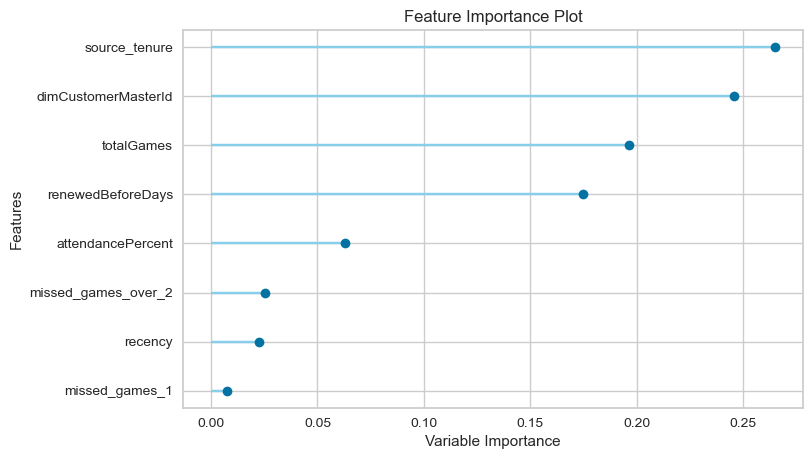

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?